In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import math

from common import *
from experiment import *
from data import DirectRawData, PlottableData

In [3]:
LOSSES = [0, 1, 2, 3, 4]
DELAYS = [1, 20, 40, 60, 80, 100]
BWS = [10, 20, 30, 40, 50]

# Plotting functions to execute parameter space for each CCA

In [4]:
# Plot function
def plot_3d_heatmap(data, xs, ys, zs):
    assert len(data.treatments) == 1
    treatment = data.treatments[0]
    loss  = {x: i for i, x in enumerate(xs)}
    delay = {y: j for j, y in enumerate(ys)}
    bw    = {z: k for k, z in enumerate(zs)}
    x, y, z = np.meshgrid(xs, ys, zs)

    # Flatten the grid for easier plotting
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    # Assign a heatmap value to each point
    # The goodput as a proportion of bottleneck bandwidth
    subdata = data.data[treatment]
    final_x = []
    final_y = []
    final_z = []
    final_values = []
    to_3d_index = lambda i, j, k: i*len(bw) + j*len(loss)*len(bw) + k
    for network_setting in data.exp.get_network_settings():
        network_data = subdata[network_setting.label()]
        if len(network_data) == 0:
            continue
        assert len(network_data) == 1

        # Calculate the index for the 3D point
        i = loss[network_setting.get('loss1')]
        j = delay[network_setting.get('delay1')]
        k = bw[network_setting.get('bw1')]
        index = to_3d_index(i, j, k)

        # Calculate and set the value for that point
        goodput = next(iter(network_data.values())).mean
        value = goodput / network_setting.get('bw1')
        final_x.append(float(x[index]))
        final_y.append(y[index])
        final_z.append(z[index])
        final_values.append(value)

        # Log the values at the edge of each dimension
        if i in [0, len(xs)-1] and j in [0, len(ys)-1] and k in [0, len(zs)-1]:
            print(f'({xs[i]},\t{ys[j]},\t{zs[k]})\t-> {value:.3f}')
    
    # Plot the 3D heatmap
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with colormap
    sc = ax.scatter(final_x, final_y, final_z, c=final_values,
        cmap='viridis', s=50, alpha=0.8, vmin=0, vmax=1)

    # Add color bar for the heatmap
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Thoughput / Bandwidth')
    
    # Add axis labels
    ax.set_xlabel('Loss')
    ax.set_ylabel('Delay')
    ax.set_zlabel('Bandwidth')
    ax.set_title(treatment)
    
    # Enable rotation
    # ax.view_init(elev=20, azim=30)  # Set initial viewing angles
    # plt.ion()  # Turn on interactive mode
    plt.show()

    # Keep the plot open in interactive mode
    # input("Press Enter to exit and close the plot.")

In [5]:
# Plot function
def plot_2d_heatmap(data, xs, ys, bw):
    assert len(data.treatments) == 1
    treatment = data.treatments[0]
    loss  = {x: i for i, x in enumerate(xs)}
    delay = {y: j for j, y in enumerate(ys)}

    # Prepare the heatmap values
    heatmap_values = np.zeros((len(ys), len(xs)))
    subdata = data.data[treatment]

    for network_setting in data.exp.get_network_settings():
        network_data = subdata[network_setting.label()]
        if len(network_data) == 0:
            continue
        assert len(network_data) == 1

        # Check if the setting matches the fixed bw
        if network_setting.get('bw1') != bw:
            continue

        # Calculate the indexes for the network setting
        i = loss[network_setting.get('loss1')]
        j = delay[network_setting.get('delay1')]

        # Calculate and set the value for that point
        goodput = next(iter(network_data.values())).mean
        value = goodput / bw
        heatmap_values[j, i] = value
    
    # Plot the 2D heatmap
    fig, ax = plt.subplots(figsize=(4, 3))
    xs = list(map(float, xs))
    cax = ax.imshow(
        heatmap_values, 
        cmap='viridis', 
        origin='lower', 
        extent=[min(xs), max(xs), min(ys), max(ys)], 
        aspect='auto', 
        vmin=0, 
        vmax=1
    )

    # Add labels to each square
    x_step = (max(xs) - min(xs)) / (len(xs))
    y_step = (max(ys) - min(ys)) / (len(ys))
    for j in range(len(ys)):
        for i in range(len(xs)):
            value = heatmap_values[j, i]
            ax.text(
                min(xs) + (i+0.5) * x_step, 
                min(ys) + (j+0.5) * y_step, 
                f'{value:.2f}', 
                ha='center', va='center', color='white', 
                fontsize=8
            )

    # Add color bar for the heatmap
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Thoughput / Bandwidth')
    
    # Add axis labels
    ax.set_xlabel('Loss')
    ax.set_ylabel('Delay')
    ax.set_title(f'{treatment} - bandwidth {bw}Mbit/s')
    plt.show()

In [6]:
def run_experiment_and_plot_heatmaps(treatment, loss=LOSSES, delay=DELAYS, bw=BWS, timeout=180, execute=False, num_trials=1, max_retries=20):
    data_size = lambda bw: int(10*1000000*bw/8)  # 10x the bottleneck bandwidth
    loss = list(map(str, loss))

    # Create experiment
    exp = Experiment(
        num_trials, [treatment], [], [],
        network_losses=loss,
        network_delays=delay,
        network_bws=bw,
        timeout=timeout,
        cartesian=False,
    )
    raw_data = DirectRawData(exp, execute=execute, max_retries=max_retries)

    # Plot data
    metric = 'throughput_mbps'
    plottable_data = PlottableData(raw_data, metric=metric)
    plot_3d_heatmap(plottable_data, xs=loss, ys=delay, zs=bw)
    fixed_bws = [bw[0], bw[1], bw[-1]]
    for fixed_bw in fixed_bws:
        plot_2d_heatmap(plottable_data, xs=loss, ys=delay, bw=fixed_bw)

# TCP

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --loss1 0 --topology direct -t 5 --label tcp_cubic tcp -cca cubic -n 12500000
(0,	1,	10)	-> 0.920
(0,	1,	50)	-> 0.933
(0,	100,	10)	-> 0.848
(0,	100,	50)	-> 0.791
(4,	1,	10)	-> 0.754
(4,	1,	50)	-> 0.378
(4,	100,	10)	-> 0.044


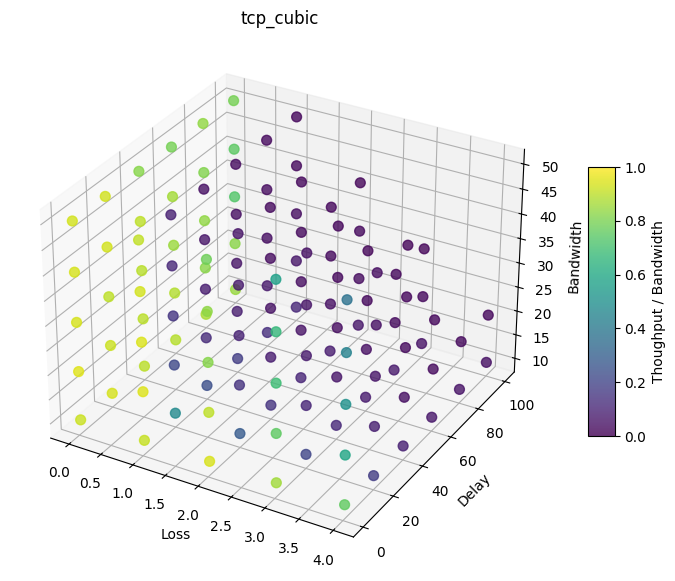

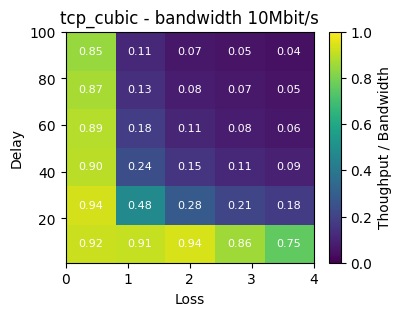

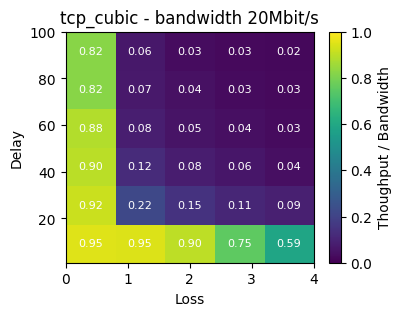

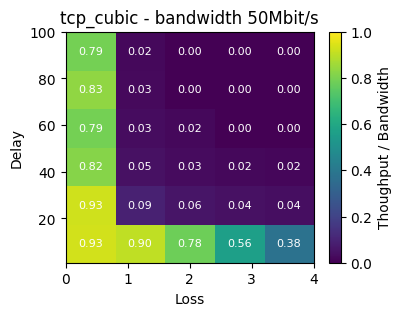

In [14]:
run_experiment_and_plot_heatmaps(
    treatment=TCP_CUBIC,
    execute=False,
    num_trials=10,
)

(0,	1,	10)	-> 0.931
(0,	1,	50)	-> 0.933
(0,	100,	10)	-> 0.836
(0,	100,	50)	-> 0.802
(4,	1,	10)	-> 0.890
(4,	1,	50)	-> 0.898
(4,	100,	10)	-> 0.754
(4,	100,	50)	-> 0.677


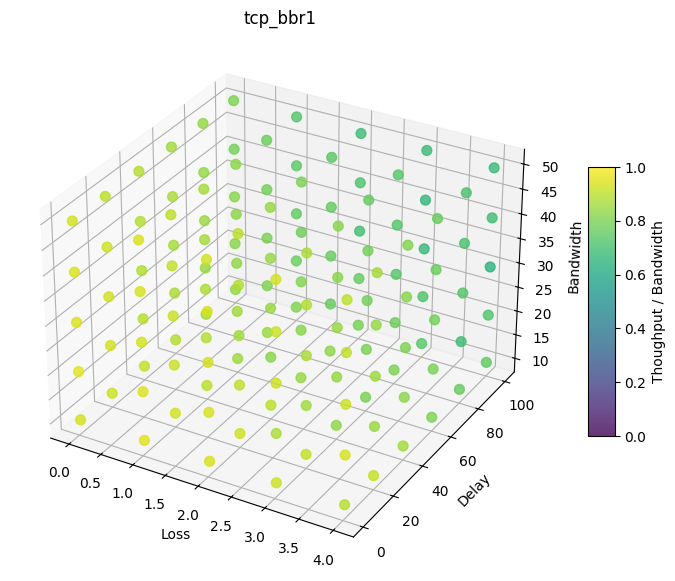

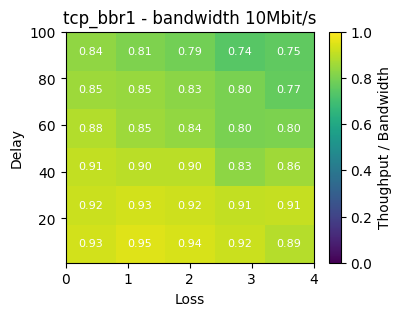

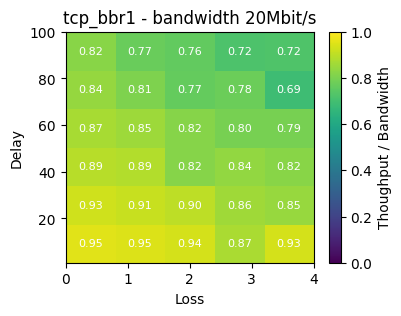

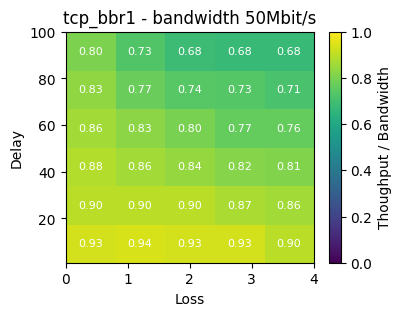

In [15]:
run_experiment_and_plot_heatmaps(
    treatment=TCP_BBRV1,
    execute=False,
    num_trials=10,
)

(0,	1,	10)	-> 0.904
(0,	1,	50)	-> 0.924
(0,	100,	10)	-> 0.804
(0,	100,	50)	-> 0.766
(4,	1,	10)	-> 0.849
(4,	1,	50)	-> 0.752
(4,	100,	10)	-> 0.501
(4,	100,	50)	-> 0.300


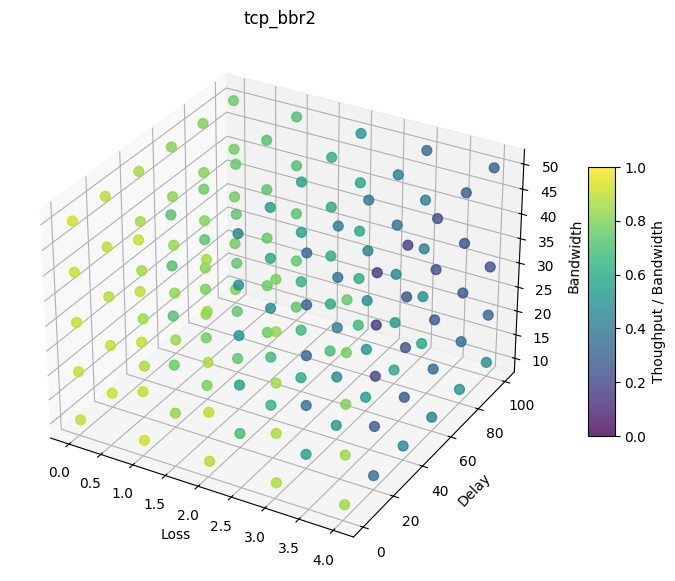

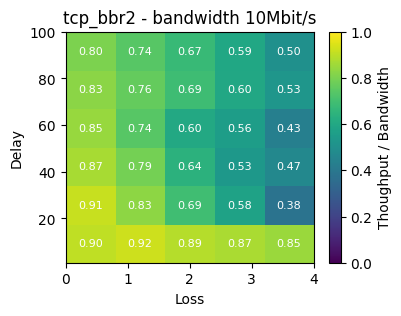

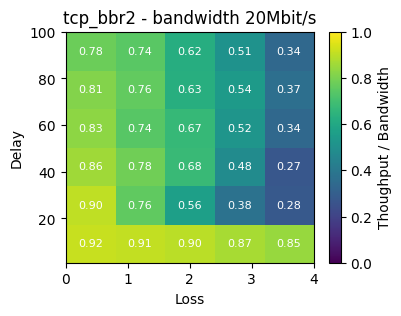

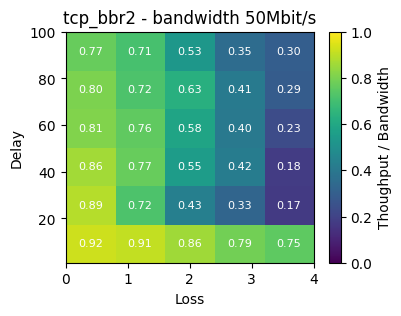

In [16]:
# Make sure the google-bbr/v2alpha Linux kernel is installed!
run_experiment_and_plot_heatmaps(
    treatment=TCP_BBRV2,
    execute=False,
    num_trials=10,
)

(0,	1,	10)	-> 0.915
(0,	1,	50)	-> 0.912
(0,	100,	10)	-> 0.820
(0,	100,	50)	-> 0.777
(4,	1,	10)	-> 0.839
(4,	1,	50)	-> 0.723
(4,	100,	10)	-> 0.479
(4,	100,	50)	-> 0.093


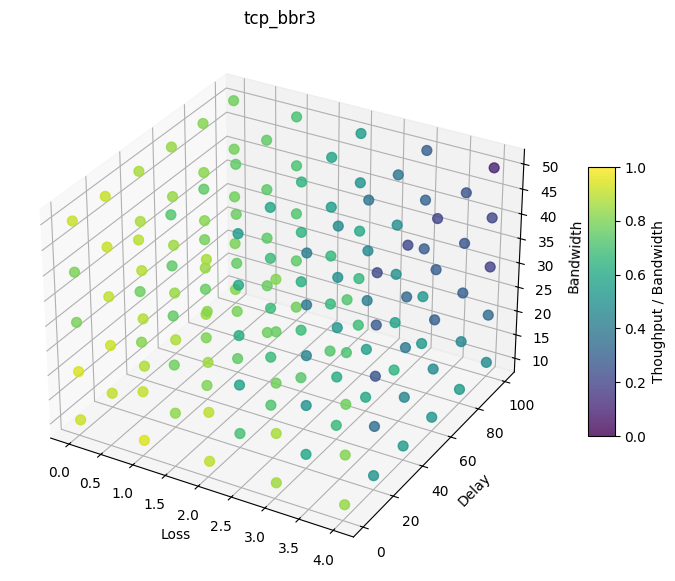

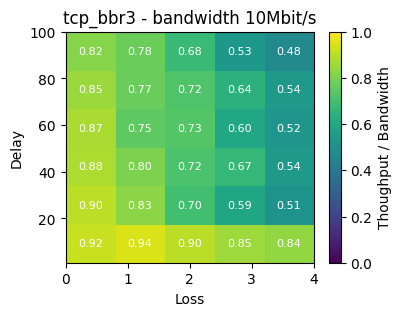

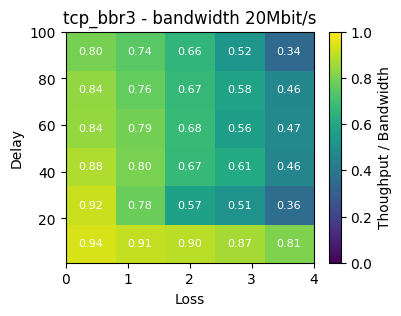

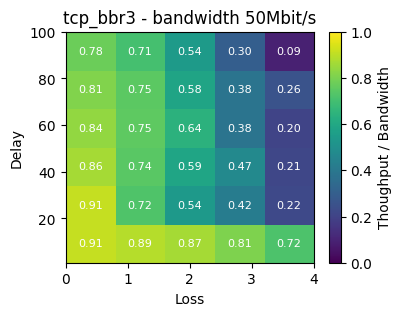

In [17]:
# Make sure the google-bbr/v3 Linux kernel is installed!
run_experiment_and_plot_heatmaps(
    treatment=TCP_BBRV3,
    execute=False,
    num_trials=10,
)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --loss1 0 --topology direct -t 5 --label tcp_reno tcp -cca reno -n 12500000
(0,	1,	10)	-> 0.916
(0,	1,	50)	-> 0.952
(0,	100,	10)	-> 0.782
(0,	100,	50)	-> 0.626
(4,	1,	10)	-> 0.872
(4,	1,	50)	-> 0.513
(4,	100,	10)	-> 0.037


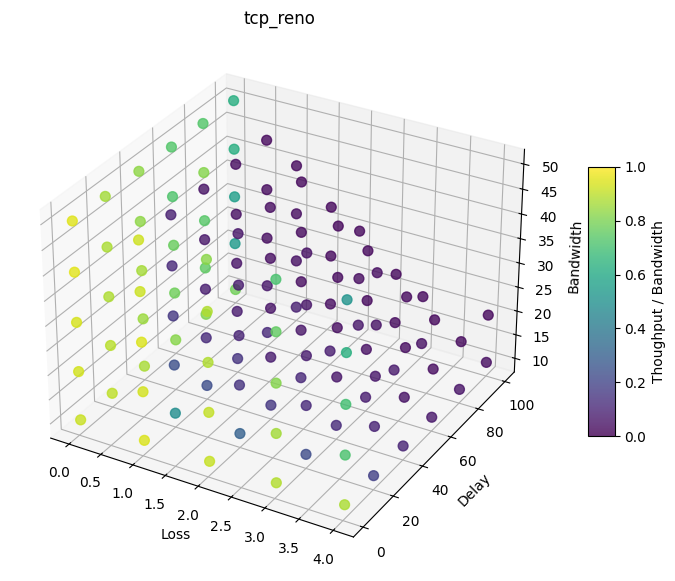

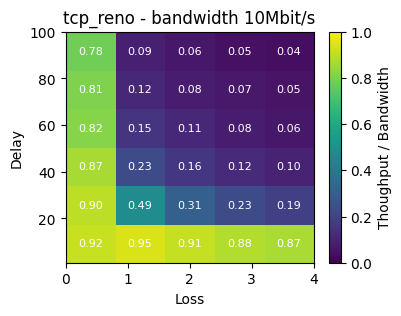

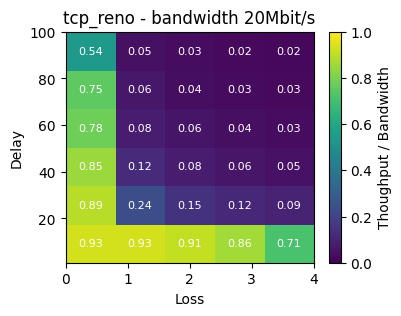

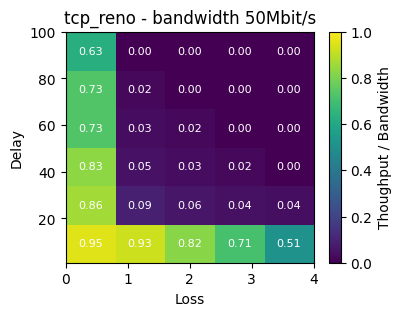

In [18]:
run_experiment_and_plot_heatmaps(
    treatment=TCP_RENO,
    execute=False,
    num_trials=10,
)

# Chromium QUIC

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 40 --loss1 3 --topology direct -t 5 --label quic_cubic quic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 30 --delay1 20 --loss1 3 --topology direct -t 5 --label quic_cubic quic -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 40 --loss1 3 --topology direct -t 5 --label quic_cubic quic -cca cubic -n 50000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay1 80 --loss1 2 --topology direct -t 5 --label quic_cubic quic -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 60 --loss1 2 --topology direct -t 5 --label quic_cubic quic -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 30 --delay1 40 --loss1 2 --topology direct -t 5 --label quic_cubic quic -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 4

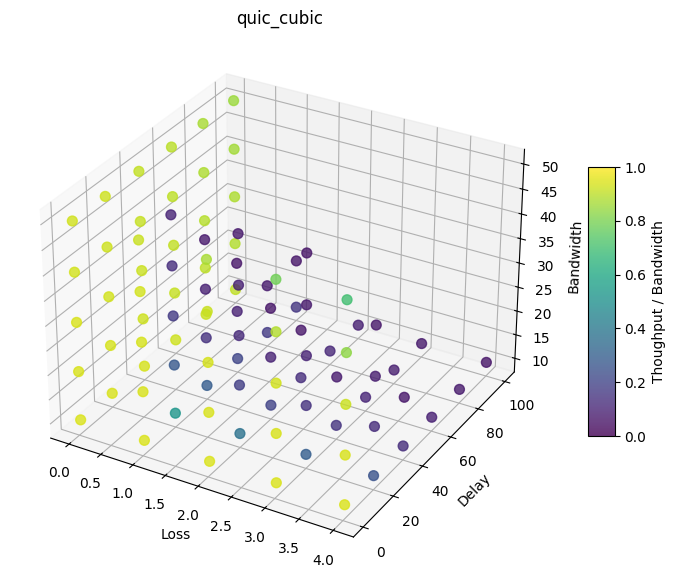

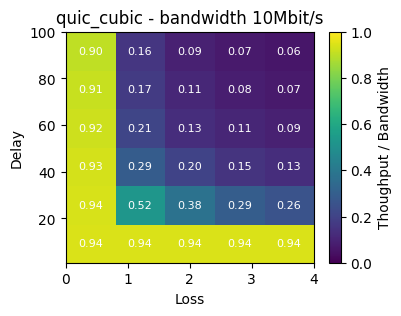

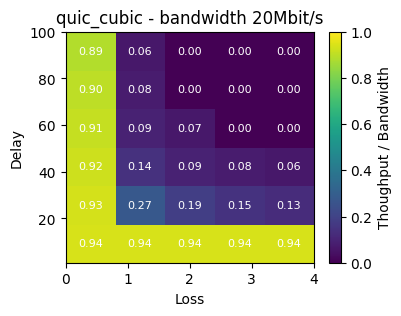

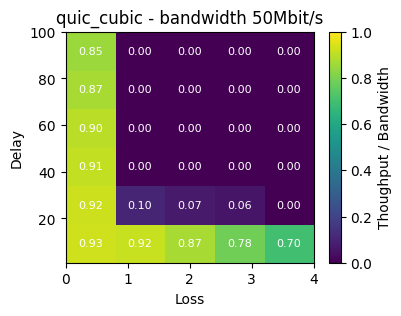

In [19]:
run_experiment_and_plot_heatmaps(
    treatment=QUIC_CUBIC,
    execute=False,
    num_trials=10,
)

(0,	1,	10)	-> 0.945
(0,	1,	50)	-> 0.917
(0,	100,	10)	-> 0.861
(0,	100,	50)	-> 0.803
(4,	1,	10)	-> 0.943
(4,	1,	50)	-> 0.913
(4,	100,	10)	-> 0.846
(4,	100,	50)	-> 0.734


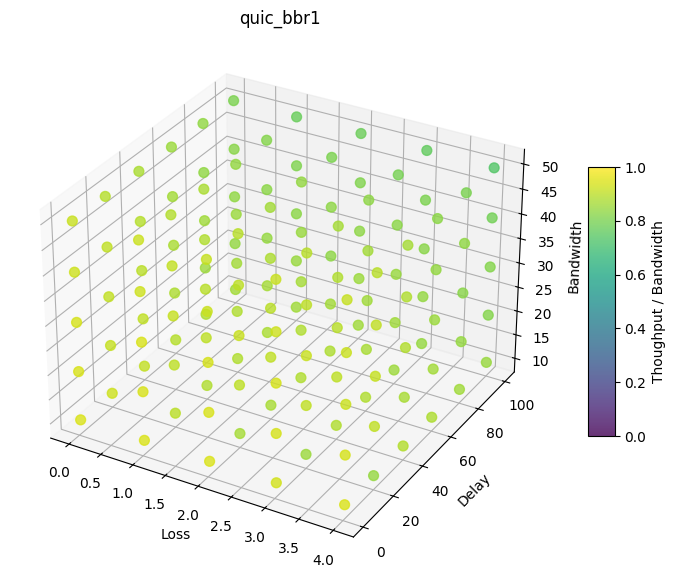

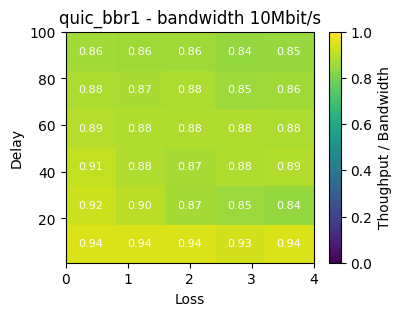

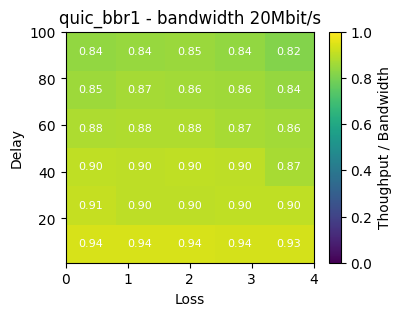

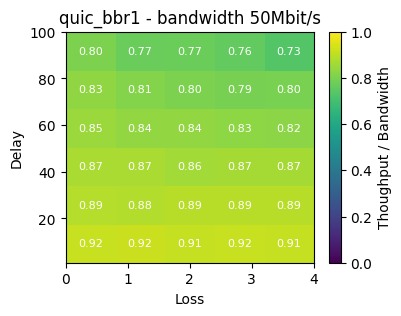

In [13]:
run_experiment_and_plot_heatmaps(
    treatment=QUIC_BBRV1,
    execute=True,
    num_trials=10,
)

(0,	1,	10)	-> 0.945
(0,	1,	50)	-> 0.925
(0,	100,	10)	-> 0.876
(0,	100,	50)	-> 0.821
(4,	1,	10)	-> 0.944
(4,	1,	50)	-> 0.916
(4,	100,	10)	-> 0.711
(4,	100,	50)	-> 0.657


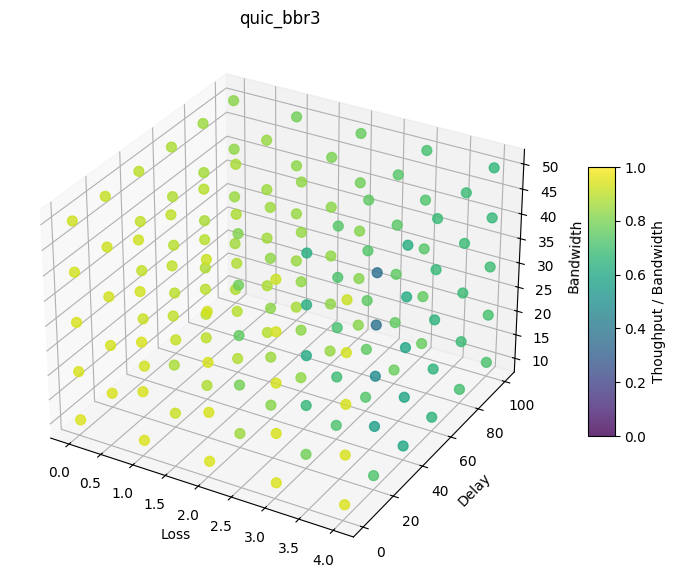

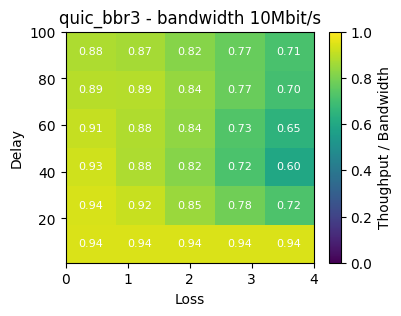

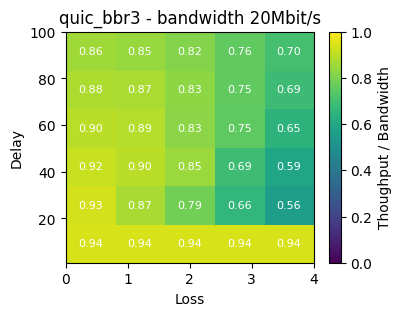

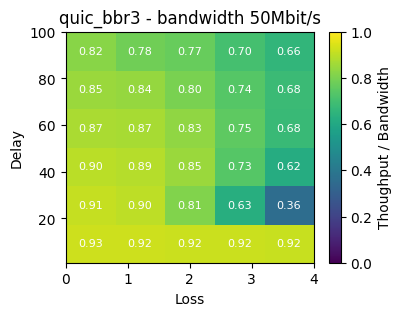

In [20]:
run_experiment_and_plot_heatmaps(
    treatment=QUIC_BBRV3,
    execute=False,
    num_trials=10,
)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay1 100 --loss1 2 --topology direct -t 9 --label quic_reno quic -cca reno -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 80 --loss1 2 --topology direct -t 9 --label quic_reno quic -cca reno -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 30 --delay1 60 --loss1 2 --topology direct -t 9 --label quic_reno quic -cca reno -n 37500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 40 --delay1 40 --loss1 2 --topology direct -t 9 --label quic_reno quic -cca reno -n 50000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 50 --delay1 20 --loss1 2 --topology direct -t 9 --label quic_reno quic -cca reno -n 62500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 100 --topology direct -t 9 --label quic_reno quic -cca reno -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 30 --dela

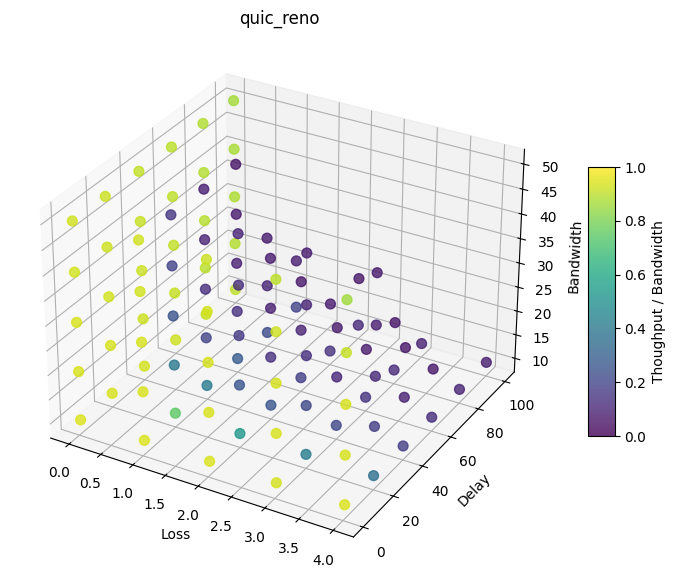

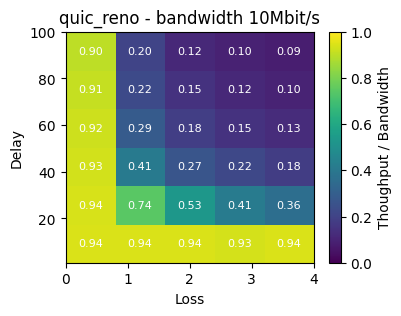

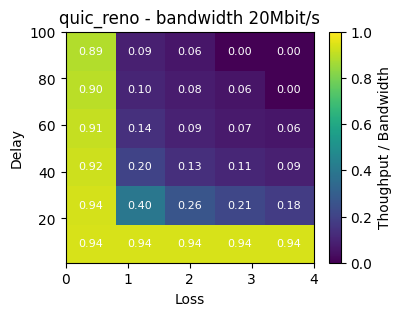

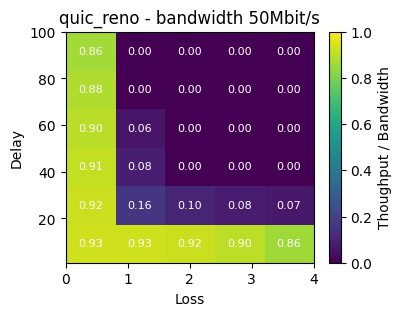

In [21]:
run_experiment_and_plot_heatmaps(
    treatment=QUIC_RENO,
    execute=False,
    num_trials=10,
)

# Cloudflare QUIC (Quiche)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 20 --loss1 4 --topology direct -t 5 --label quiche_cubic quiche -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 30 --loss1 4 --topology direct -t 5 --label quiche_cubic quiche -cca cubic -n 37500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay1 60 --loss1 3 --topology direct -t 5 --label quiche_cubic quiche -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 40 --loss1 3 --topology direct -t 5 --label quiche_cubic quiche -cca cubic -n 50000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay1 80 --loss1 2 --topology direct -t 5 --label quiche_cubic quiche -cca cubic -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 60 --loss1 2 --topology direct -t 5 --label quiche_cubic quiche -cca cubic -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout

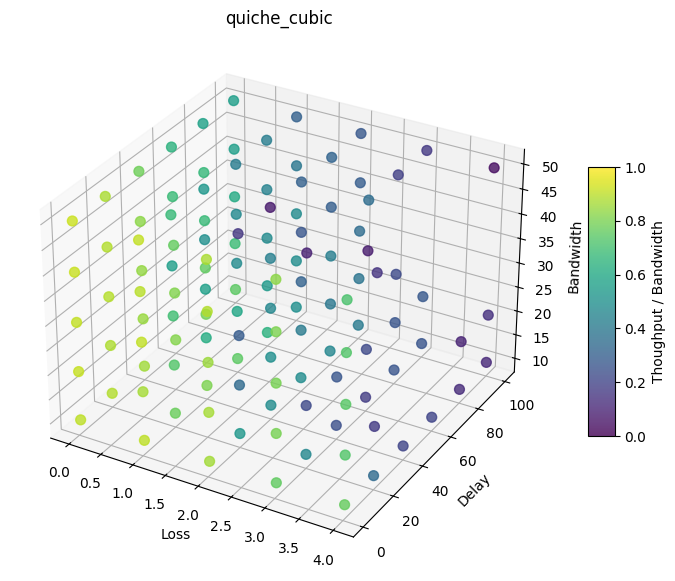

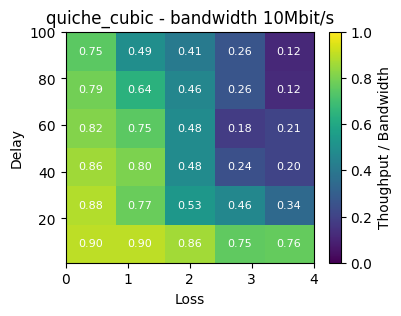

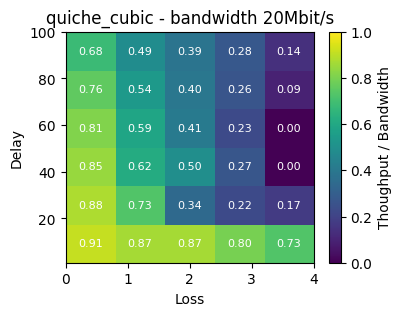

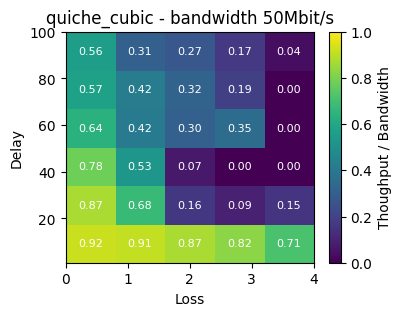

In [23]:
run_experiment_and_plot_heatmaps(
    treatment=QUICHE_CUBIC,
    execute=False,
    num_trials=10,
)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 50 --delay1 80 --loss1 0 --topology direct -t 5 --label quiche_bbr1 quiche -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay1 100 --loss1 4 --topology direct -t 5 --label quiche_bbr1 quiche -cca bbr -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 20 --delay1 80 --loss1 4 --topology direct -t 5 --label quiche_bbr1 quiche -cca bbr -n 25000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 30 --delay1 60 --loss1 4 --topology direct -t 5 --label quiche_bbr1 quiche -cca bbr -n 37500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 40 --delay1 40 --loss1 4 --topology direct -t 5 --label quiche_bbr1 quiche -cca bbr -n 50000000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 50 --delay1 20 --loss1 4 --topology direct -t 5 --label quiche_bbr1 quiche -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --

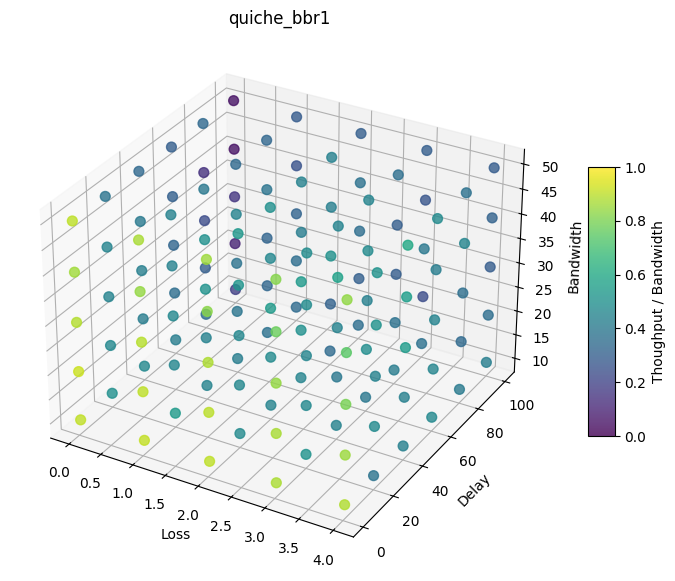

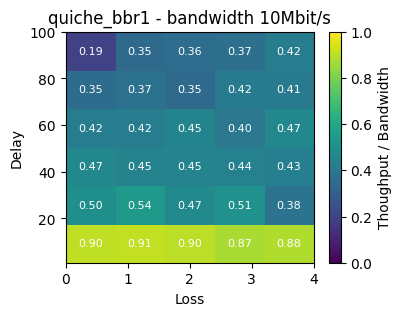

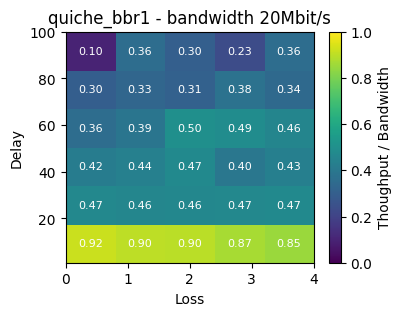

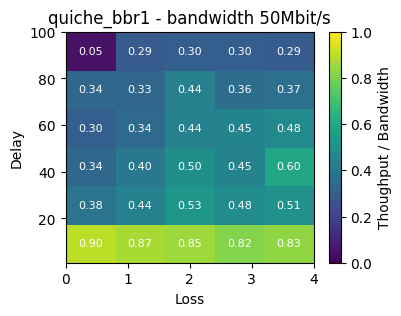

In [24]:
run_experiment_and_plot_heatmaps(
    treatment=QUICHE_BBRV1,
    execute=False,
    num_trials=10,
)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --loss1 0 --topology direct -t 5 --label quiche_bbr2 quiche -cca bbr -n 12500000
(0,	1,	10)	-> 0.886
(0,	1,	50)	-> 0.922
(0,	100,	10)	-> 0.181
(4,	1,	10)	-> 0.875
(4,	1,	50)	-> 0.873
(4,	100,	10)	-> 0.297
(4,	100,	50)	-> 0.201


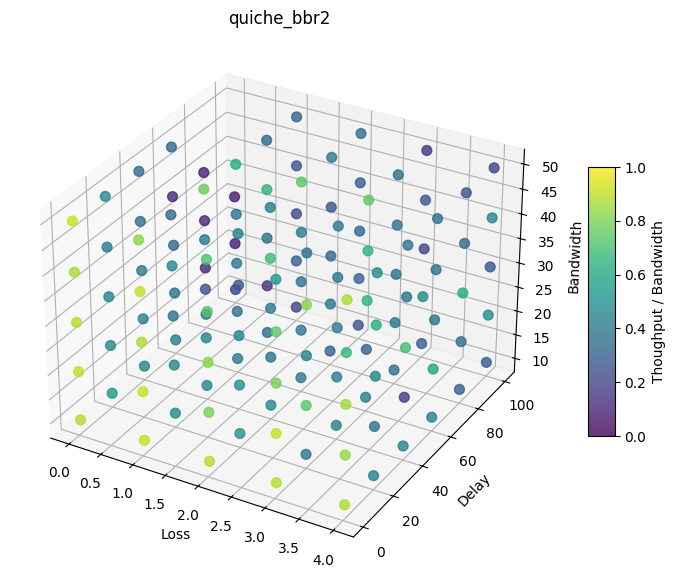

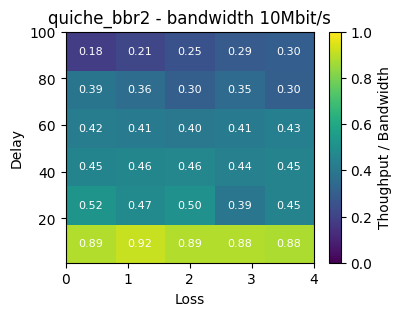

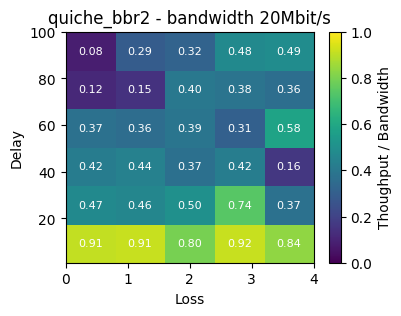

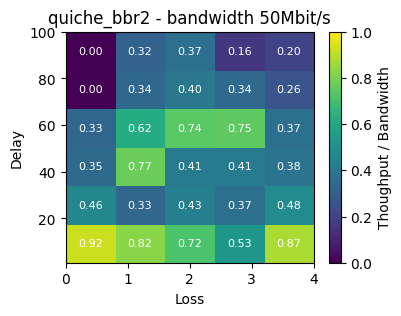

In [25]:
run_experiment_and_plot_heatmaps(
    treatment=QUICHE_BBRV2,
    execute=False,
    num_trials=10,
)

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --loss1 0 --topology direct -t 9 --label quiche_reno quiche -cca reno -n 12500000
(0,	1,	10)	-> 0.818
(0,	1,	50)	-> 0.917
(0,	100,	10)	-> 0.755
(4,	1,	10)	-> 0.551


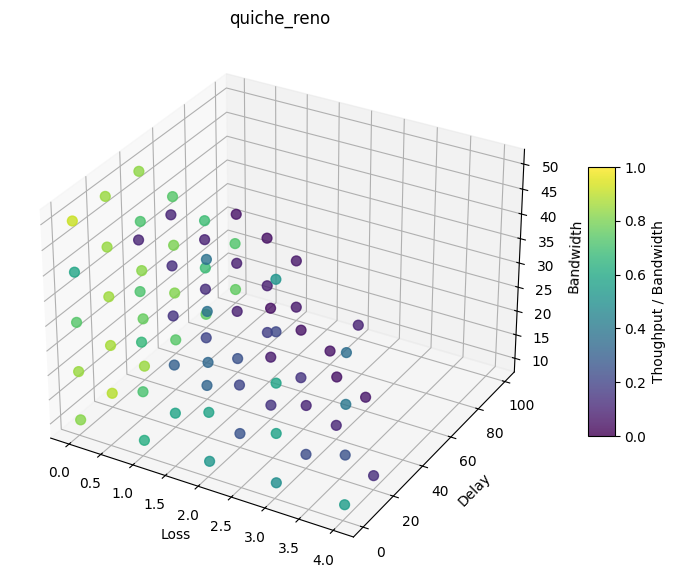

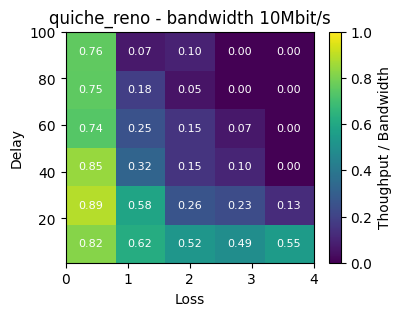

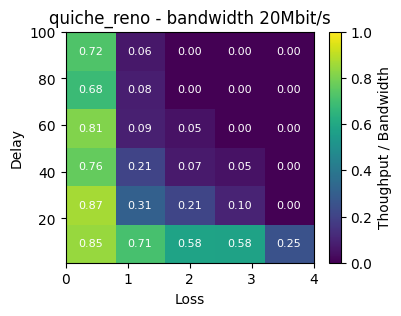

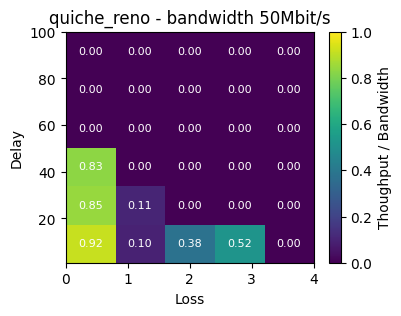

In [27]:
run_experiment_and_plot_heatmaps(
    treatment=QUICHE_RENO,
    execute=False,
    num_trials=10,
)